In [1]:

import sys
sys.path.append('/Users/clancy/repos/meg')


import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy.linalg as LA
from numpy.linalg import norm
from dipole_class import DipoleLocalizer
from data_generator_class import DataGenerator
import mpld3

np.set_printoptions(threshold=np.inf, precision=16, suppress=True,linewidth=100)
#%matplotlib notebook

In [2]:

config_file = "configs/brainNoise.yaml"

# initialize dipole with config file
dip_loc = DipoleLocalizer(config_file) 

# create DataGenerator object using configuration passed to dip_loc
dip_gen = DataGenerator(dip_loc)  


n_s = 3
n_t = 1000
S = np.zeros((n_s, n_t))

# establish time values and signals from different sources
ts = np.linspace(0,2*np.pi,n_t)
S[0,:] = signal.sawtooth(5*ts)
S[1,:] = np.sign(np.sin(3*ts + .4))
S[2,:] = np.cos(2*ts) 


#S[0,:] = np.sin(5*ts)
#S[0,:] = np.sin(2*ts)
#S[1,:] = np.sin(3*ts + .4)
#S[2,:] = np.sin(2*ts) 


Ps = np.zeros((n_s, 3))
Qs = np.zeros((n_s, 3))

minBrainNoise = 1e-13
maxBrainNoise = 40e-11
numDipoles = 1000
minDepthRatio = 0.5
maxDepthRatio = 0.75 
rInner = .07
rOuter = 0.085
n_sensors = dip_loc.settings['sensors']['num_sensors']

# initialize true mixing matrix
# each column will be the lead field at p_i multiplied to orientation q_i,
#  i.e. L(p_i) q_i
A = np.zeros((n_sensors, n_s))


for i, s in enumerate(S):
    # draw random unit dipole spherical hemisphere
    p,q = dip_gen.get_random_unit_dipole(rInner, rOuter)

    # store dipole location and orientation
    #if i == 1:
    #    p = Ps[0,:] + np.random.normal(0,.002,(3,))
    #    q = Qs[0,:]
    Ps[i,:] = p
    Qs[i,:] = q

    # generate lead field from dipole location and simulate magentic field 
    L = dip_gen.lead_field_obj.get_lead_field(p)  
    a = .5e-8*L@q

    A[:,i] = a
    # create signal matrix from one of the components
    Bclean = np.outer(a,s) if i == 0 else (Bclean + np.outer(a,s))

ret = dip_gen.simulate_brain_noise(minBrainNoise, maxBrainNoise, 
                                    numDipoles, minDepthRatio, maxDepthRatio, n_t)

brainNoise = ret[0]

B = Bclean + brainNoise



Text(0, 0.5, 'Mag fields (T)')

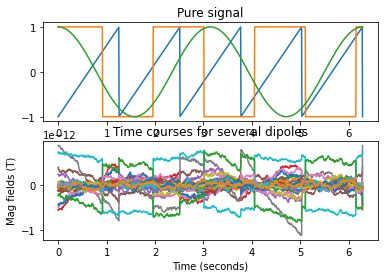

In [3]:
plt.subplot(2,1,1)
plt.plot(ts,S.T);
plt.title('Pure signal')
plt.subplot(2,1,2)
plt.plot(ts,B.T);
plt.title('Time courses for several dipoles')
plt.xlabel('Time (seconds)')
plt.ylabel('Mag fields (T)')

In [4]:
ret = dip_loc.localize_multiple_sources(B, 3, method='ica')


Calculating lead fields...this might take a little while


In [5]:
P_ = ret[0]

In [6]:
print(P_)
print(Ps)


[[-0.0683516462482944  0.0322924351990755  0.0227058889318631]
 [-0.0200155462628757  0.041832576411955   0.0590465780250595]
 [-0.0382109368786838  0.0516985121161312  0.054784643210931 ]]
[[-0.0220071827254416  0.0460183539767404  0.0534391531396853]
 [-0.0679306737609412  0.0326173690851761  0.0224694329148293]
 [-0.0191681227938707  0.0413186023315344  0.0609661942176611]]


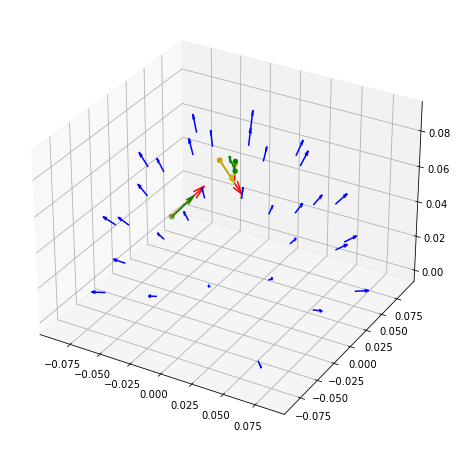

In [7]:
# plot the true dipole locations and orientations
# also plot the estimate dipole locations and their orientations

Pest = ret[1]   # this takes finely resolved dipole
Qest = ret[3]   # finely resolved orientation
Qest = (Qest.T/LA.norm(Qest,axis=1)).T

Pestc = ret[0]   # this takes finely resolved dipole
Qestc = ret[2]   # finely resolved orientation
Qestc = (Qestc.T/LA.norm(Qestc,axis=1)).T

p_true = Ps
q_true = (Qs.T/LA.norm(Qs,axis=1)).T


sensors = dip_loc.sensors
sensor_dirs = dip_loc.sensor_directions
#"""
# plot true and estimated dipole locations and moments along with sensor locations
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection='3d');

scat = ax.scatter(p_true[:,0], p_true[:,1], p_true[:,2], label='True dipole', color='g')
scat = ax.quiver(p_true[:,0], p_true[:,1], p_true[:,2], q_true[:,0], q_true[:,1], q_true[:,2], color='g', length=.02)

scat = ax.scatter(Pest[:,0], Pest[:,1], Pest[:,2], label='True dipole', color='r')
scat = ax.quiver(Pest[:,0], Pest[:,1], Pest[:,2], Qest[:,0], Qest[:,1], Qest[:,2], color='r', length=.03)

scat = ax.scatter(Pestc[:,0], Pestc[:,1], Pestc[:,2], label='True dipole', color='y')
scat = ax.quiver(Pestc[:,0], Pestc[:,1], Pestc[:,2], Qestc[:,0], Qestc[:,1], Qestc[:,2], color='y', length=.02)

scat = ax.quiver(sensors[:,0], sensors[:,1], sensors[:,2], sensor_dirs[:,0], sensor_dirs[:,1], sensor_dirs[:,2], length=0.01, color='b')
#plt.show()
#"""